1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklift.models import SoloModel
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from catboost import CatBoostClassifier

In [2]:
cust_ret = pd.read_csv('../data.csv')
cust_ret.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [3]:
cust_ret = cust_ret.rename(columns={'conversion':'target','offer':'treatment'})
cust_ret.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [4]:
cust_ret.groupby("treatment")["treatment"].value_counts()

treatment        treatment      
Buy One Get One  Buy One Get One    21387
Discount         Discount           21307
No Offer         No Offer           21306
Name: treatment, dtype: int64

In [5]:
value_trans = {'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0}

In [6]:
cust_ret['treatment'] = cust_ret['treatment'].map(value_trans)

In [7]:
cust_ret.groupby("treatment")["treatment"].value_counts()

treatment  treatment
0          0            21306
1          1            42694
Name: treatment, dtype: int64

In [8]:
cust_ret = pd.get_dummies(cust_ret, columns=['zip_code','channel'])

In [9]:
X = cust_ret.loc[:, cust_ret.columns != 'target']
X.head(3)

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,1,0,0,1,0
1,6,329.08,1,1,1,0,1,0,0,0,0,1
2,7,180.65,0,1,1,1,0,1,0,0,0,1


In [10]:
y = cust_ret.loc[:, cust_ret.columns == 'target' ]['target']
y

0        0
1        0
2        0
3        0
4        0
        ..
63995    0
63996    0
63997    0
63998    0
63999    0
Name: target, Length: 64000, dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm.fit(X_train, y_train, X_train.loc[:,"treatment"]);

In [13]:
uplift_sm = sm.predict(X_test)

In [14]:
models_results = {
    'model': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [15]:
sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test.loc[:,"treatment"], \
                          strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test.loc[:,"treatment"], \
                         strategy='by_group', k=0.2)
models_results['model'].append("SoloModel")
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

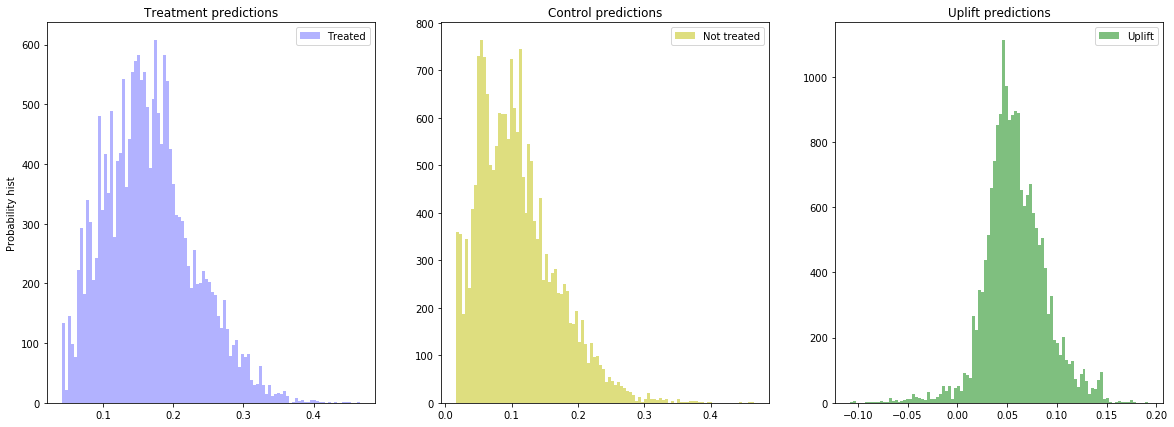

In [16]:
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [17]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,17.260413
1,treatment,16.414997
2,recency,14.259660
3,history,12.844428
4,used_bogo,11.718604
5,used_discount,7.995969
6,zip_code_Rural,6.822888
7,channel_Phone,4.727113
8,channel_Web,3.440637
9,zip_code_Surburban,2.698195


In [18]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, X_train.loc[:,"treatment"])

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test.loc[:,"treatment"],\
                          strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test.loc[:,"treatment"],\
                          strategy='by_group', k=0.2)

In [19]:
models_results['model'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

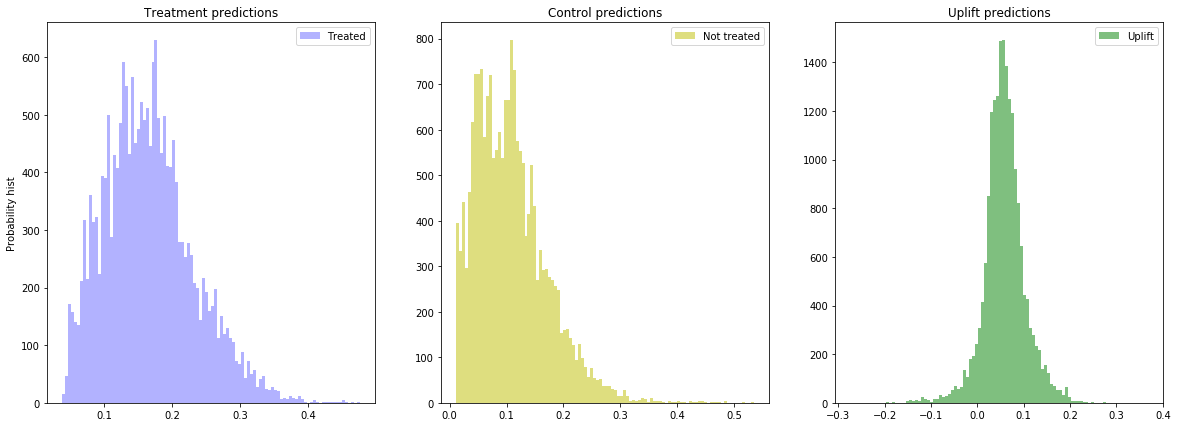

In [20]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(X_train, y_train, X_train.loc[:,"treatment"])

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test.loc[:, "treatment"],\
                          strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test.loc[:, "treatment"],\
                          strategy='by_group', k=0.2)

models_results['model'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [21]:
pd.DataFrame(models_results)

,model,uplift@10%,uplift@20%
0,SoloModel,0.089921,0.073974
1,ClassTransformation,0.265577,0.218362
2,TwoModels,0.081392,0.070171
